In [1]:
import os
import pandas as pd
import openslide
import matplotlib.pyplot as plt
import pickle
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel

In [5]:
df= pd.read_csv("/home/jantao/109_info.csv")
df= df.sort_values(by= "data_id").reset_index(drop= True)
row = df[df["patient_barcode"] == "TCGA-AA-3532"]
#print(row)
#print(df.loc[df["patient_barcode"] == "TCGA-AA-3664", "rna_files"])
value = df.loc[df["patient_barcode"] == "TCGA-AA-3532", "image_path"].iloc[0]
print(value)
#df

/data_g1/AI_projects/raw_data/TCGA_CRC/TCGA_CRC_WSIs/TCGA_COAD/d22cced9-3126-4072-a418-5a3863df2b7e/TCGA-AA-3532-01Z-00-DX1.00c7a378-a7c5-4fb4-9f53-6197be81c2eb.svs


In [6]:
count= 0
folder_path= "/data_g1/AI_projects/raw_data/TCGA_CRC/TCGA_CRC_WSIs/TCGA_COAD"
for subfolder_name in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder_name)
    if not os.path.isdir(subfolder_path):
        continue
    for file in os.listdir(subfolder_path):
        if not file.endswith(".svs"):
            continue
        count+= 1
print(count)

459


In [35]:
image_codes= []
csv_path= "/home/jantao/TCGA_Validation_109WSIs.csv"
df= pd.read_csv(csv_path)
df= df.sort_values("patient_barcode")
df["patient_barcode"]

69     TCGA-3L-AA1B
38     TCGA-3L-AA1B
94     TCGA-5M-AAT4
98     TCGA-5M-AATE
25     TCGA-A6-2681
40     TCGA-A6-2684
68     TCGA-A6-2685
54     TCGA-A6-3809
0      TCGA-A6-3810
24     TCGA-A6-4107
49     TCGA-A6-5660
11     TCGA-A6-5662
88     TCGA-A6-6651
8      TCGA-A6-A565
28     TCGA-AA-3518
71     TCGA-AA-3519
10     TCGA-AA-3522
51     TCGA-AA-3527
12     TCGA-AA-3532
9      TCGA-AA-3560
47     TCGA-AA-3562
104    TCGA-AA-3664
7      TCGA-AA-3696
18     TCGA-AA-3837
5      TCGA-AA-3867
56     TCGA-AA-3949
6      TCGA-AA-3952
19     TCGA-AA-3956
86     TCGA-AA-3966
14     TCGA-AA-3967
2      TCGA-AA-3972
13     TCGA-AA-3977
53     TCGA-AA-3979
15     TCGA-AA-3982
96     TCGA-AA-3986
48     TCGA-AA-3994
67     TCGA-AA-A00A
16     TCGA-AA-A00U
17     TCGA-AA-A01G
76     TCGA-AA-A01R
32     TCGA-AA-A01S
29     TCGA-AA-A02E
50     TCGA-AA-A02R
3      TCGA-AD-6901
41     TCGA-AF-2691
35     TCGA-AF-2692
37     TCGA-AF-3400
46     TCGA-AF-3911
61     TCGA-AF-4110
73     TCGA-AF-6672


In [12]:
csv_path= "/data_g1/AI_projects/raw_data/TCGA_CRC/Transcriptome_Profiling/Gene_Expression_Quantification/TCGA-COAD/00ae9ab8-6eaa-4085-af72-26f96df97fa3/90c9f8cd-4c8c-4f07-af2f-e17db69bd561.rna_seq.augmented_star_gene_counts.tsv"
df= pd.read_csv(csv_path, sep="\t", skiprows= 1)
df

,gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded
0,N_unmapped,NaN,NaN,2294349,2294349,2294349,NaN,NaN,NaN
1,N_multimapping,NaN,NaN,10874851,10874851,10874851,NaN,NaN,NaN
2,N_noFeature,NaN,NaN,17117059,77433868,17558743,NaN,NaN,NaN
3,N_ambiguous,NaN,NaN,7253582,85129,4731374,NaN,NaN,NaN
4,ENSG00000000003.15,TSPAN6,protein_coding,7476,0,7476,102.6828,30.3660,26.9821
...,...,...,...,...,...,...,...,...,...
60659,ENSG00000288669.1,AC008763.4,protein_coding,0,0,0,0.0000,0.0000,0.0000
60660,ENSG00000288670.1,AL592295.6,lncRNA,365,0,369,12.5845,3.7216,3.3068
60661,ENSG00000288671.1,AC006486.3,protein_coding,0,0,0,0.0000,0.0000,0.0000
60662,ENSG00000288674.1,AL391628.1,protein_coding,16,2,14,0.1036,0.0306,0.0272


In [7]:
csv_path= "/home/jantao/TCGA_Validation_109WSIs.csv"
rna_path= "/data_g1/AI_projects/raw_data/TCGA_CRC/Transcriptome_Profiling/tcga_query_results.csv"
cell_path= "/data_g1/AI_projects/raw_data/TCGA_CRC/tcga_crc_metadata.csv"
df= pd.read_csv(csv_path)
rna_df= pd.read_csv(rna_path)
cell_df= pd.read_csv(cell_path)
df= df[["data_id", "patient_barcode", "image_path"]]
cancer_types= []
rna_paths= {}

for _, row in df.iterrows():
    parts= row["image_path"].split(os.sep)
    cancer_type= parts[-3]
    cancer_type = cancer_type.replace("_", "-")
    cancer_types.append(cancer_type)
    image_name= row["patient_barcode"]
    matches = rna_df[rna_df["cases.submitter_id"] == image_name]
    
    for _, row in matches.iterrows():
        file_name= row["file_name"]
        folder_id= row["id"]

        if image_name not in rna_paths:
            rna_paths[image_name] = []
        path= os.path.join("/data_g1/AI_projects/raw_data/TCGA_CRC/Transcriptome_Profiling/Gene_Expression_Quantification/", cancer_type, folder_id, file_name)
        rna_paths[image_name].append(path)
        
df["cancer_type"]= cancer_types
df["rna_files"] = df["patient_barcode"].map(rna_paths)
df = df.merge(
    cell_df[["data_id", "cell_data_path"]],
    on="data_id",
    how="left"   # keep all rows in df, even if missing in cell_df
)
df.to_csv("/home/jantao/109_info.csv")

In [36]:
rna_path= "/data_g1/AI_projects/raw_data/TCGA_CRC/Transcriptome_Profiling/tcga_query_results.csv"
rna_df= pd.read_csv(rna_path)
rna_df

,id,data_format,cases,access,file_name,submitter_id,data_category,type,platform,file_size,...,analysis_id,analysis_state,analysis_submitter_id,analysis_workflow_link,analysis_workflow_type,analysis_workflow_version,sample_type,is_ffpe,cases.submitter_id,sample.submitter_id
0,2c73d8ac-84b9-4094-9f5e-fbd6c2e8eabf,TSV,TCGA-AA-3688-01A-01R-0905-07,open,c8c7600d-2c13-4df1-b058-2d02432bd49e.rna_seq.a...,f537e95c-c9d6-4c2a-b2be-27b066bb5b7a,Transcriptome Profiling,gene_expression,Illumina,4216302,...,f6d042c0-cb43-4a76-9758-6012d09e2098,released,c8c7600d-2c13-4df1-b058-2d02432bd49e_star__counts,quay.io/ncigdc,STAR - Counts,470801dfbc085958058a5b50518e4f3a5e4721c3,Primary Tumor,NaN,TCGA-AA-3688,TCGA-AA-3688-01A
1,7389dfaa-fa36-431f-a3b9-960b4fb9d836,TSV,TCGA-G4-6298-01A-11R-1723-07,open,20ed86b0-2e3d-44ec-88cd-eac5486fe15c.rna_seq.a...,d9da2203-4969-425c-8546-18a8002f3340,Transcriptome Profiling,gene_expression,Illumina,4222773,...,5dcd5d17-5a5e-4bd2-a774-f73763ddbfe9,released,20ed86b0-2e3d-44ec-88cd-eac5486fe15c_star__counts,https://github.com/NCI-GDC/gdc-rnaseq-cwl/blob...,STAR - Counts,5d8c131bbff59fb0c969217fc1d44e6d1503cd1f,Primary Tumor,NaN,TCGA-G4-6298,TCGA-G4-6298-01A
2,d77dfe53-77dd-46c9-80a4-19d343e8ee36,TSV,TCGA-AA-3672-01A-01R-0905-07,open,d6b7de60-321d-4f6d-82e7-3d5e9598462c.rna_seq.a...,bde7c085-f1d1-440b-8e31-ae146ab60c30,Transcriptome Profiling,gene_expression,Illumina,4178966,...,289cdc38-3816-464f-8c38-4a623fbface6,released,d6b7de60-321d-4f6d-82e7-3d5e9598462c_star__counts,quay.io/ncigdc,STAR - Counts,470801dfbc085958058a5b50518e4f3a5e4721c3,Primary Tumor,NaN,TCGA-AA-3672,TCGA-AA-3672-01A
3,456e94a2-2a07-426c-9857-3d71647393a9,TSV,TCGA-G4-6314-01A-11R-1723-07,open,f825534d-5882-4efe-a32e-af56741854f6.rna_seq.a...,a50b1473-d153-403c-bc87-bacdc1292e3c,Transcriptome Profiling,gene_expression,Illumina,4237288,...,da0847f7-c374-485b-af31-8a701d6f4b76,released,f825534d-5882-4efe-a32e-af56741854f6_star__counts,https://github.com/NCI-GDC/gdc-rnaseq-cwl/blob...,STAR - Counts,5d8c131bbff59fb0c969217fc1d44e6d1503cd1f,Primary Tumor,NaN,TCGA-G4-6314,TCGA-G4-6314-01A
4,d6af00a8-d733-4788-aaf4-8522479eba2d,TSV,TCGA-A6-2682-01A-01R-1410-07,open,d25af392-21ad-4aa6-8669-34656bf71af5.rna_seq.a...,fecf75ae-7ce7-4b2e-a983-7caf29b36d9f,Transcriptome Profiling,gene_expression,Illumina,4194374,...,1797ecd4-1fe7-4336-9ba0-85af2a16ca28,released,d25af392-21ad-4aa6-8669-34656bf71af5_star__counts,quay.io/ncigdc,STAR - Counts,470801dfbc085958058a5b50518e4f3a5e4721c3,Primary Tumor,NaN,TCGA-A6-2682,TCGA-A6-2682-01A
5,411ef195-13d2-4c3a-b8df-b3e6150fe73d,TSV,TCGA-AA-3562-01A-02R-0821-07,open,d22c9285-50cf-4724-9f81-606fb54c00fc.rna_seq.a...,c8a371b0-fcb9-451e-85be-0bac8111c2bf,Transcriptome Profiling,gene_expression,Illumina,4215553,...,09fd99b7-6b5f-4fe7-9065-ed1e252445ec,released,d22c9285-50cf-4724-9f81-606fb54c00fc_star__counts,quay.io/ncigdc,STAR - Counts,470801dfbc085958058a5b50518e4f3a5e4721c3,Primary Tumor,NaN,TCGA-AA-3562,TCGA-AA-3562-01A
6,fb6ca177-100e-4b2a-8a8f-b127b058a11c,TSV,TCGA-AA-3979-01A-01R-1022-07,open,81b828aa-cb06-4790-ba3e-efaa39f4eeef.rna_seq.a...,e8e9bd60-6400-4dd4-a3af-68a2f7ff6492,Transcriptome Profiling,gene_expression,Illumina,4205980,...,c37e961e-cde8-4a7b-9822-c7ade0ec1f6d,released,81b828aa-cb06-4790-ba3e-efaa39f4eeef_star__counts,quay.io/ncigdc,STAR - Counts,470801dfbc085958058a5b50518e4f3a5e4721c3,Primary Tumor,NaN,TCGA-AA-3979,TCGA-AA-3979-01A
7,52defb9b-4d00-4e24-a4ed-7a2742660ac6,TSV,TCGA-AA-3524-01A-02R-0821-07,open,8824c0fd-764e-4525-952b-f25efa742772.rna_seq.a...,ccb60849-569e-4bc9-89ce-f14f141821de,Transcriptome Profiling,gene_expression,Illumina,4185488,...,acf9bfe3-e21e-4c46-a483-e4f4fed47bdf,released,8824c0fd-764e-4525-952b-f25efa742772_star__counts,quay.io/ncigdc,STAR - Counts,470801dfbc085958058a5b50518e4f3a5e4721c3,Primary Tumor,NaN,TCGA-AA-3524,TCGA-AA-3524-01A
8,69ccf4e3-15a5-4e1d-91af-402100e85349,TSV,TCGA-DM-A285-01A-11R-A16W-07,open,3bc40056-88b6-483c-8701-747eb6e851c4.rna_seq.a...,a3331746-2e5b-4a8

In [29]:
csv_path= "/data_g1/AI_projects/raw_data/TCGA_CRC/Transcriptome_Profiling/tcga_query_results.csv"
df= pd.read_csv(csv_path)
df.columns#["cases"][1]
# id stores the folder for bulk rna info: data_g1/AI_projects/raw_data/TCGA_CRC/Transcriptome_Profiling/Gene_Expression_Quantification/TCGA-COAD
# file_name is the file within the folder

Index(['id', 'data_format', 'cases', 'access', 'file_name', 'submitter_id',
       'data_category', 'type', 'platform', 'file_size', 'created_datetime',
       'md5sum', 'updated_datetime', 'file_id', 'data_type', 'state',
       'experimental_strategy', 'version', 'data_release', 'project',
       'analysis_id', 'analysis_state', 'analysis_submitter_id',
       'analysis_workflow_link', 'analysis_workflow_type',
       'analysis_workflow_version', 'sample_type', 'is_ffpe',
       'cases.submitter_id', 'sample.submitter_id'],
      dtype='object')

In [78]:
#pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [52]:
csv_path= "/data_g1/AI_projects/raw_data/TCGA_CRC/tcga_crc_metadata.csv"
df= pd.read_csv(csv_path)
#dupes= df[df.duplicated("data_id", keep= False)]
#print(dupes.sort_values("data_id"))
df= df.sort_values(by= "data_id")
df["cell_data_path"][0]
# each row of cell_data_path of this csv shows the file path to cell distribution

'/data_g1/AI_projects/raw_data/TCGA_CRC/TCGA_CRC_WSIs/0003_TCGA_COADREAD_final_data/20200222_tcga_coad_read_cells_final/TCGA-AD-6895-01Z-00-DX1.7FB1FBC6-683B-4285-89D1-A7A20F07A9D4.txt'

In [29]:
csv_path= "/data_g1/AI_projects/raw_data/TCGA_CRC/patient_multiple_spls.csv"
df= pd.read_csv(csv_path)
df
# conversion_factors show the conversion factor

,patient_ids,cell_fnms,conversion_factors,patient_barcode
0,TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5...,TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5...,0.2527,TCGA-3L-AA1B
1,TCGA-3L-AA1B-01Z-00-DX2.17CE3683-F4B1-4978-A28...,TCGA-3L-AA1B-01Z-00-DX2.17CE3683-F4B1-4978-A28...,0.2527,TCGA-3L-AA1B
2,TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891...,TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891...,0.2527,TCGA-4N-A93T
3,TCGA-4N-A93T-01Z-00-DX2.875E7F95-A6D4-4BEB-A33...,TCGA-4N-A93T-01Z-00-DX2.875E7F95-A6D4-4BEB-A33...,0.2527,TCGA-4N-A93T
4,TCGA-AA-A01F-01Z-00-DX1.A09E4A5B-1DD2-472C-B38...,NaN,0.2325,NaN
5,TCGA-AA-A01I-01Z-00-DX1.D24F43B2-F46E-4F7F-85A...,NaN,0.2325,NaN
6,TCGA-AF-3914-01Z-00-DX1.d7bb7792-df51-498b-9d1...,TCGA-AF-3914-01Z-00-DX1.d7bb7792-df51-498b-9d1...,0.2520,TCGA-AF-3914
7,TCGA-AF-3914-01Z-00-DX2.493568CE-EAC1-400D-87E...,TCGA-AF-3914-01Z-00-DX2.493568CE-EAC1-400D-87E...,0.2465,TCGA-AF-3914
8,TCGA-NH-A6GC-01Z-00-DX1.29073D7E-5EEF-4BBA-96B...,TCGA-NH-A6GC-01Z-00-DX1.29073D7E-5EEF-4BBA-96B...,0.2525,TCGA-NH-A6GC
9,TCGA-NH-A6GC-06Z-00-DX1.5F90CBDB-794B-498D-B75...,TCGA-NH-A6GC-06Z-00-DX1.5F90CBDB-794B-498D-B75...,0.2525,TCGA-NH-A6GC


In [31]:
csv_path= "/data_g1/AI_projects/raw_data/TCGA_CRC/Clinical_Data/TCGA-COAD/clinical.tsv"
df= pd.read_csv(csv_path, sep="\t")
df

,project.project_id,cases.case_id,cases.consent_type,cases.days_to_consent,cases.days_to_lost_to_followup,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,demographic.age_at_index,demographic.age_is_obfuscated,demographic.cause_of_death,demographic.cause_of_death_source,demographic.country_of_birth,demographic.country_of_residence_at_enrollment,demographic.days_to_birth,demographic.days_to_death,demographic.demographic_id,demographic.education_level,demographic.ethnicity,demographic.gender,demographic.marital_status,demographic.occupation_duration_years,demographic.population_group,demographic.premature_at_birth,demographic.race,demographic.submitter_id,demographic.vital_status,demographic.weeks_gestation_at_birth,demographic.year_of_birth,demographic.year_of_death,diagnoses.adrenal_hormone,diagnoses.age_at_diagnosis,diagnoses.ajcc_clinical_m,diagnoses.ajcc_clinical_n,diagnoses.ajcc_clinical_stage,diagnoses.ajcc_clinical_t,diagnoses.ajcc_pathologic_m,diagnoses.ajcc_pathologic_n,diagnoses.ajcc_pathologic_stage,diagnoses.ajcc_pathologic_t,diagnoses.ajcc_serum_tumor_markers,diagnoses.ajcc_staging_system_edition,diagnoses.ann_arbor_b_symptoms,diagnoses.ann_arbor_b_symptoms_described,diagnoses.ann_arbor_clinical_stage,diagnoses.ann_arbor_extranodal_involvement,diagnoses.ann_arbor_pathologic_stage,diagnoses.best_overall_response,diagnoses.burkitt_lymphoma_clinical_variant,diagnoses.calgb_risk_group,diagnoses.cancer_detection_method,diagnoses.child_pugh_classification,diagnoses.clark_level,diagnoses.classification_of_tumor,diagnoses.cog_liver_stage,diagnoses.cog_neuroblastoma_risk_group,diagnoses.cog_renal_stage,diagnoses.cog_rhabdomyosarcoma_risk_group,diagnoses.contiguous_organ_invaded,diagnoses.days_to_best_overall_response,diagnoses.days_to_diagnosis,diagnoses.days_to_last_follow_up,diagnoses.days_to_last_known_disease_status,diagnoses.days_to_recurrence,diagnoses.diagnosis_id,diagnoses.diagnosis_is_primary_disease,diagnoses.double_expressor_lymphoma,diagnoses.double_hit_lymphoma,diagnoses.eln_risk_classification,diagnoses.enneking_msts_grade,diagnoses.enneking_msts_metastasis,diagnoses.enneking_msts_stage,diagnoses.enneking_msts_tumor_site,diagnoses.ensat_clinical_m,diagnoses.ensat_pathologic_n,diagnoses.ensat_pathologic_stage,diagnoses.ensat_pathologic_t,diagnoses.esophageal_columnar_dysplasia_degree,diagnoses.esophageal_columnar_metaplasia_present,diagnoses.fab_morphology_code,diagnoses.figo_stage,diagnoses.figo_staging_edition_year,diagnoses.first_symptom_longest_duration,diagnoses.first_symptom_prior_to_diagnosis,diagnoses.gastric_esophageal_junction_involvement,diagnoses.gleason_grade_group,diagnoses.gleason_grade_tertiary,diagnoses.gleason_patterns_percent,diagnoses.gleason_score,diagnoses.goblet_cells_columnar_mucosa_present,diagnoses.icd_10_code,diagnoses.igcccg_stage,diagnoses.inpc_grade,diagnoses.inpc_histologic_group,diagnoses.inrg_stage,diagnoses.inss_stage,diagnoses.international_prognostic_index,diagnoses.irs_group,diagnoses.irs_stage,diagnoses.ishak_fibrosis_score,diagnoses.iss_stage,diagnoses.last_known_disease_status,diagnoses.laterality,diagnoses.margin_distance,diagnoses.margins_involved_site,diagnoses.masaoka_stage,diagnoses.max_tumor_bulk_site,diagnoses.medulloblastoma_molecular_classification,diagnoses.melanoma_known_primary,diagnoses.metastasis_at_diagnosis,diagnoses.metastasis_at_diagnosis_site,diagnoses.method_of_diagnosis,diagnoses.micropapillary_features,diagnoses.mitosis_karyorrhexis_index,diagnoses.mitotic_count,diagnoses.morphology,diagnoses.ovarian_specimen_status,diagnoses.ovarian_surface_involvement,diagnoses.papillary_renal_cell_type,diagnoses.pediatric_kidney_staging,diagnoses.peritoneal_fluid_cytological_status,diagnoses.pregnant_at_diagnosis,diagnoses.primary_diagnosis,diagnoses.primary_disease,diagnoses.primary_gleason_grade,diagnoses.prior_malignancy,diagnoses.prior_treatment,diagnoses.progression_or_recurrence,diagnoses.residual_disease,diagn

In [112]:
file_path = '/data_g1/AI_projects/raw_data/TCGA_CRC/TCGA_CRC_WSIs/0003_TCGA_COADREAD_final_data/20200222_tcga_coad_read_cells_final/TCGA-CA-6717-01Z-00-DX1.08da75b7-a08f-46b3-a8c0-24f601ec4558.txt'
conversion_factor= "/data_g1/AI_projects/raw_data/TCGA_CRC/patient_multiple_spls.csv"
df = pd.read_csv(file_path, sep="\t", encoding="latin-1", header=0, engine="python")
factor_df= pd.read_csv(conversion_factor)
df.columns = df.columns.str.strip()
df = df.map(lambda v: v.strip() if isinstance(v, str) else v)
for col in ("Centroid X µm", "Centroid Y µm"):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")  # invalid -> NaN
df= df.rename(columns= {"Name": "cell_label"})
df= df.drop(["Class", "ROI"], axis= 1)
df["Centroid X µm"]= df["Centroid X µm"]/ 0.252
df["Centroid Y µm"]= df["Centroid Y µm"]/ 0.252
df["Centroid Y µm"].max()
#df["Centroid Y µm"].min()
#df["cell_label"].unique()
# each file is shows the coordinates of each cell in micrometers?

47678.57142857143

In [37]:
def load_slide(slide_path, level=0):
    slide = openslide.OpenSlide(slide_path)
    w, h = slide.level_dimensions[level]
    img = slide.read_region((0, 0), level, (w, h)).convert("RGB")
    mpp_x = float(slide.properties.get("openslide.mpp-x", "nan"))
    mpp_y = float(slide.properties.get("openslide.mpp-y", "nan"))
    #plt.figure()
    #plt.imshow(img)
    #plt.axis("off")
    #plt.show()
    
    return slide, img, w, h, mpp_x, mpp_y
load_slide('/data_g1/AI_projects/raw_data/TCGA_CRC/TCGA_CRC_WSIs/TCGA_COAD/70012428-8df8-4eb2-8d28-7d0b2a88d1d7/TCGA-A6-3810-01Z-00-DX1.2940ca70-013a-4bc3-ad6a-cf4d9ffa77ce.svs')

(OpenSlide('/data_g1/AI_projects/raw_data/TCGA_CRC/TCGA_CRC_WSIs/TCGA_COAD/70012428-8df8-4eb2-8d28-7d0b2a88d1d7/TCGA-A6-3810-01Z-00-DX1.2940ca70-013a-4bc3-ad6a-cf4d9ffa77ce.svs'),
 <PIL.Image.Image image mode=RGB size=27818x25991>,
 27818,
 25991,
 0.252,
 0.252)

In [7]:
factor_df

,patient_ids,cell_fnms,conversion_factors,patient_barcode
0,TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5...,TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5...,0.2527,TCGA-3L-AA1B
1,TCGA-3L-AA1B-01Z-00-DX2.17CE3683-F4B1-4978-A28...,TCGA-3L-AA1B-01Z-00-DX2.17CE3683-F4B1-4978-A28...,0.2527,TCGA-3L-AA1B
2,TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891...,TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891...,0.2527,TCGA-4N-A93T
3,TCGA-4N-A93T-01Z-00-DX2.875E7F95-A6D4-4BEB-A33...,TCGA-4N-A93T-01Z-00-DX2.875E7F95-A6D4-4BEB-A33...,0.2527,TCGA-4N-A93T
4,TCGA-AA-A01F-01Z-00-DX1.A09E4A5B-1DD2-472C-B38...,NaN,0.2325,NaN
5,TCGA-AA-A01I-01Z-00-DX1.D24F43B2-F46E-4F7F-85A...,NaN,0.2325,NaN
6,TCGA-AF-3914-01Z-00-DX1.d7bb7792-df51-498b-9d1...,TCGA-AF-3914-01Z-00-DX1.d7bb7792-df51-498b-9d1...,0.2520,TCGA-AF-3914
7,TCGA-AF-3914-01Z-00-DX2.493568CE-EAC1-400D-87E...,TCGA-AF-3914-01Z-00-DX2.493568CE-EAC1-400D-87E...,0.2465,TCGA-AF-3914
8,TCGA-NH-A6GC-01Z-00-DX1.29073D7E-5EEF-4BBA-96B...,TCGA-NH-A6GC-01Z-00-DX1.29073D7E-5EEF-4BBA-96B...,0.2525,TCGA-NH-A6GC
9,TCGA-NH-A6GC-06Z-00-DX1.5F90CBDB-794B-498D-B75...,TCGA-NH-A6GC-06Z-00-DX1.5F90CBDB-794B-498D-B75...,0.2525,TCGA-NH-A6GC


In [6]:
deepspot_df= pd.read_csv("/home/jantao/deepspot_109/summary.csv")
deepspot_df= deepspot_df.drop(["Bulk RNA Pearson", "Bulk RNA logged Pearson"], axis= 1)
deepspot_df.rename(columns={"Unnamed: 0": "Image code", 'Bulk RNA Spearman': 'Deepspot Bulk RNA Spearman'}, inplace=True)
deepspot_df= deepspot_df.set_index("Image code")
deepspot_df.index = deepspot_df.index.astype(str).str[:-1] + "-" + deepspot_df.index.astype(str).str[-1]
sequoia_df= pd.read_csv("/home/jantao/sequoia_109/summary.csv")
sequoia_df= sequoia_df.drop(["Bulk RNA Pearson", "Bulk RNA logged Pearson"], axis= 1)
sequoia_df.rename(columns={"Unnamed: 0": "Image code", 'Bulk RNA Spearman': 'SEQUOIA Bulk RNA Spearman', "Unnamed: 0": "Image code"}, inplace=True)
sequoia_df= sequoia_df.set_index("Image code")
sequoia_df.index = sequoia_df.index.astype(str).str.replace(r"^TCGA-?", "", regex=True)
merged_df = pd.concat([deepspot_df, sequoia_df], axis= 1)
merged_df

,Deepspot Bulk RNA Spearman,SEQUOIA Bulk RNA Spearman
Image code,,
A6-3810-0,0.732438,0.969433
A6-3810-1,0.706913,0.934932
A6-3810-2,0.491129,0.694325
AG-3611-0,0.699449,0.947175
AA-3972-0,0.729261,0.969904
...,...,...
AA-3664-0,0.761915,0.957126
CM-6162-0,0.693017,0.980091
D5-5540-0,0.632915,0.948398


In [7]:
mean_df= merged_df.copy()
mean_df['Base Image'] = merged_df.index.str.rsplit('-', n=1).str[0]
mean_df = mean_df.groupby('Base Image').mean()
model_avg = mean_df.mean()
print(mean_df)
print(model_avg)

            Deepspot Bulk RNA Spearman  SEQUOIA Bulk RNA Spearman
Base Image                                                       
3L-AA1B                       0.693945                   0.975967
5M-AAT4                       0.668758                   0.974590
5M-AATE                       0.672227                   0.972386
A6-2681                       0.719051                   0.974244
A6-2684                       0.630608                   0.853382
...                                ...                        ...
G4-6310                       0.636666                   0.957583
G4-6627                       0.732538                   0.979715
G5-6235                       0.669171                   0.946572
NH-A6GA                       0.676519                   0.960927
NH-A8F8                       0.703707                   0.972078

[106 rows x 2 columns]
Deepspot Bulk RNA Spearman    0.697212
SEQUOIA Bulk RNA Spearman     0.962443
dtype: float64


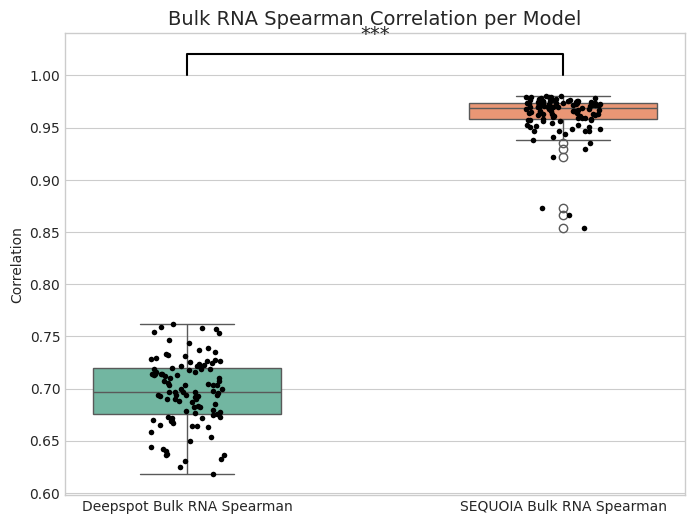

In [14]:
t_stat, p_val = ttest_rel(
    mean_df["Deepspot Bulk RNA Spearman"],
    mean_df["SEQUOIA Bulk RNA Spearman"]
)

# Map p-value to stars
def get_sig_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

sig_label = get_sig_stars(p_val)

plt.figure(figsize=(8,6))

# Boxplot
ax = sns.boxplot(
    data=mean_df,
    palette="Set2",
    width=0.5
)

# Add jittered points
sns.stripplot(
    data=mean_df,
    color="black",
    size=4,
    jitter=True,
    dodge=True
)

# Title and labels
plt.title("Bulk RNA Spearman Correlation per Model", fontsize=14)
plt.ylabel("Correlation")

# Add significance annotation above the boxes
x1, x2 = 0, 1     # positions of boxes (0 = first, 1 = second)
y, h = mean_df.max().max() + 0.02, 0.02  # y position and height of line
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
ax.text((x1+x2)*.5, y+h+0.01, sig_label, ha='center', va='bottom', fontsize=14)

plt.show()

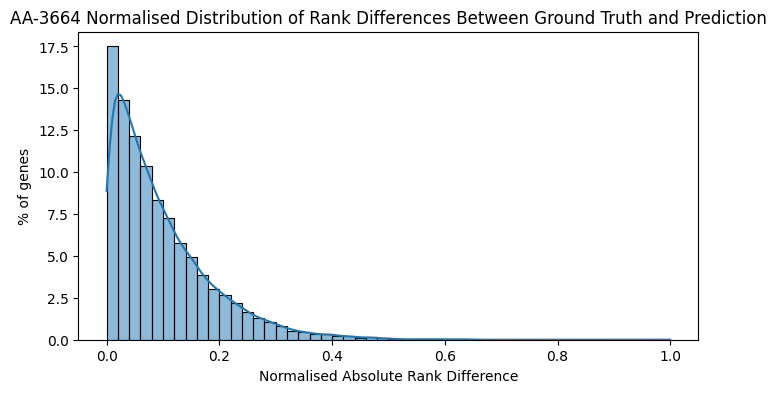

In [2]:
rna_pkl= "/home/jantao/sequoia_109/uni_results/sequoia_109/test_results.pkl"
with open(rna_pkl, "rb") as f:
    data = pickle.load(f)
df= pd.DataFrame(data["pred"])
row = df.loc["TCGA-AA-3664-01Z-00-DX1.bd07e7ef-0acb-43d8-a4f6-15b3442d2ed5"]
row = row.to_frame(name="predicted")
rna_pkl= "/home/jantao/sequoia_109/uni_results/sequoia_109/test_results.pkl"
link= '/data_g1/AI_projects/raw_data/TCGA_CRC/Transcriptome_Profiling/Gene_Expression_Quantification/TCGA-COAD/699928b7-738d-44a8-bbcf-a8e58c34112f/5b217223-8b43-47b6-a694-c808b643c3c3.rna_seq.augmented_star_gene_counts.tsv'
gt_df= pd.read_csv(link, sep="\t", skiprows=1)
gt_df = gt_df[["gene_name", "tpm_unstranded"]].dropna(subset=["gene_name"])
gt_df= gt_df[gt_df["tpm_unstranded"]> 0]
gt_df= gt_df[gt_df["gene_name"].isin(row.index)].copy()
gt_df["predicted"]= gt_df["gene_name"].map(row["predicted"])
gt_df= gt_df.sort_values("gene_name", ascending= True)
gt_df["tpm_unstranded"] = pd.to_numeric(gt_df["tpm_unstranded"], errors='coerce')
gt_df["predicted"] = pd.to_numeric(gt_df["predicted"], errors='coerce')
gt_df.dropna(subset=["tpm_unstranded", "predicted"], inplace=True)
gt_df["expression_rank"]= gt_df["tpm_unstranded"].rank()
gt_df["prediction_rank"]= gt_df["predicted"].rank()
gt_df["expression_log"] = np.log1p(gt_df["tpm_unstranded"])
gt_df["pred_log"] = np.log1p(gt_df["predicted"])
gt_df["rank_diff"] = (gt_df["expression_rank"] - gt_df["prediction_rank"]).abs()
plt.figure(figsize=(8,4))
max_rank = gt_df["rank_diff"].max()
gt_df["rank_diff_norm"] = gt_df["rank_diff"] / max_rank
sns.histplot(gt_df["rank_diff_norm"], bins=50, kde=True, stat= "percent")
plt.xlabel("Normalised Absolute Rank Difference")
plt.ylabel("% of genes")
plt.title("AA-3664 Normalised Distribution of Rank Differences Between Ground Truth and Prediction")
plt.show()

/tmp/ipykernel_1832807/3924717268.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csv= pd.read_csv(csv_path)


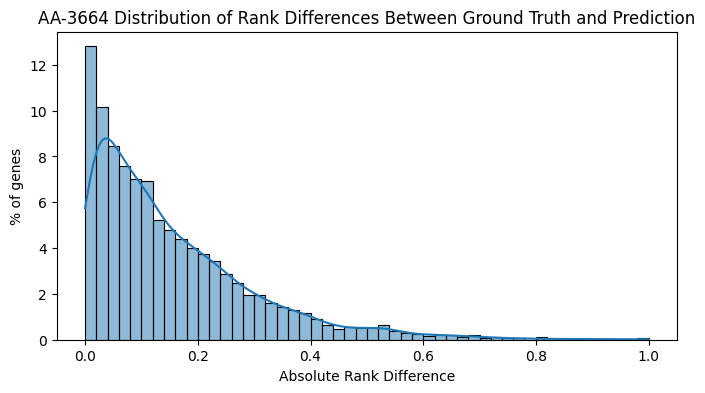

In [3]:
csv_path= "/home/jantao/deepspot_109/AA-3664/edited_AA-3664.csv"
df_csv= pd.read_csv(csv_path)
csv_avg = df_csv.iloc[-1, 5:]
csv_avg.index = df_csv.columns[5:]
rna_file_path= '/data_g1/AI_projects/raw_data/TCGA_CRC/Transcriptome_Profiling/Gene_Expression_Quantification/TCGA-COAD/699928b7-738d-44a8-bbcf-a8e58c34112f/5b217223-8b43-47b6-a694-c808b643c3c3.rna_seq.augmented_star_gene_counts.tsv'
rna_df = pd.read_csv(rna_file_path, sep="\t", skiprows=1)
rna_df = rna_df[["gene_name", "tpm_unstranded"]].dropna(subset=["gene_name"])
rna_df= rna_df[rna_df["tpm_unstranded"]> 0]
common_genes = rna_df["gene_name"].isin(csv_avg.index)
rna_df = rna_df.loc[common_genes].copy()
rna_df["csv_avg"] = rna_df["gene_name"].map(csv_avg)
rna_df= rna_df.sort_values("gene_name", ascending= True)
rna_df["tpm_unstranded"] = pd.to_numeric(rna_df["tpm_unstranded"], errors='coerce')
rna_df["csv_avg"] = pd.to_numeric(rna_df["csv_avg"], errors='coerce')
rna_df.dropna(subset=["tpm_unstranded", "csv_avg"], inplace=True)
rna_df["expression_rank"]= rna_df["tpm_unstranded"].rank()
rna_df["prediction_rank"]= rna_df["csv_avg"].rank()
rna_df["expression_log"] = np.log1p(rna_df["tpm_unstranded"])
rna_df["pred_log"] = np.log1p(rna_df["csv_avg"])
rna_df["rank_diff"] = (rna_df["expression_rank"] - rna_df["prediction_rank"]).abs()
plt.figure(figsize=(8,4))
max_rank = rna_df["rank_diff"].max()
rna_df["rank_diff_norm"] = rna_df["rank_diff"] / max_rank
sns.histplot(rna_df["rank_diff_norm"], bins=50, kde=True, stat= "percent")
plt.xlabel("Absolute Rank Difference")
plt.ylabel("% of genes")
plt.title("AA-3664 Distribution of Rank Differences Between Ground Truth and Prediction")
plt.show()

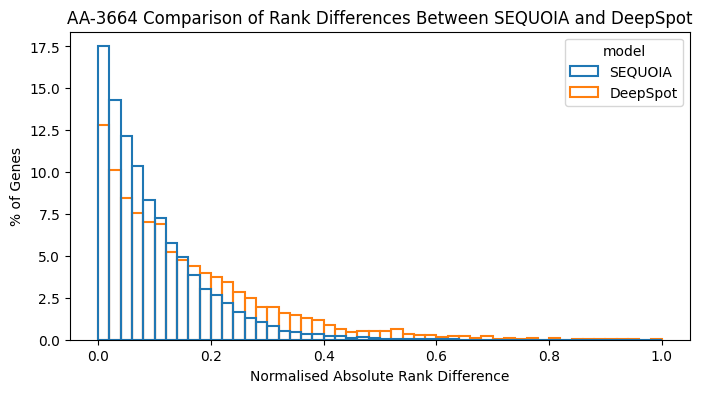

In [5]:
sequoia_df = gt_df.copy()
sequoia_df["model"] = "SEQUOIA"
deepspot_df = rna_df.copy()
deepspot_df["model"] = "DeepSpot"
combined_df = pd.concat([sequoia_df[["rank_diff_norm","model"]],
                         deepspot_df[["rank_diff_norm","model"]]])
plt.figure(figsize=(8,4))
sns.histplot(
    data=combined_df,
    x="rank_diff_norm",
    hue="model",
    bins=50,
    stat="percent",
    multiple="layer",   # overlapping bars
    common_norm=False,  # % computed per model
    fill=False,         # only outline, no fill
    linewidth=1.5       # thickness of the outline
)

plt.xlabel("Normalised Absolute Rank Difference")
plt.ylabel("% of Genes")
plt.title("AA-3664 Comparison of Rank Differences Between SEQUOIA and DeepSpot")
plt.show()

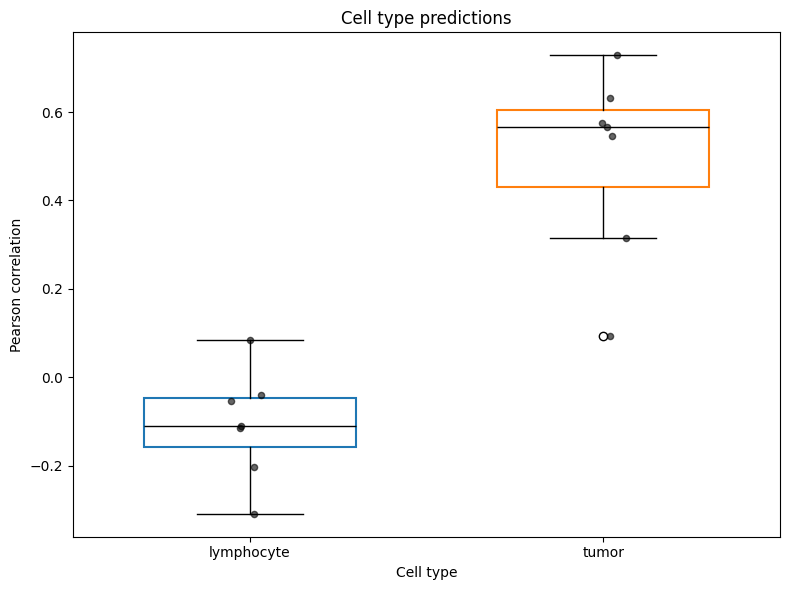

In [13]:
df = pd.read_csv("/home/jantao/DeepSpot/test_data/coad images summary.csv")
for col in ["Bulk RNA Pearson", "Bulk RNA logged Pearson", "Bulk RNA Spearman"]:
    if col in df.columns:
        df = df.drop(columns=col)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) == 0:
    coerced_cols = []
    for c in df.columns:
        coerced = pd.to_numeric(df[c], errors="coerce")
        if coerced.notna().sum() > 0:
            df[c] = coerced
            coerced_cols.append(c)
    numeric_cols = coerced_cols

if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found — check your CSV or drop non-numeric columns first.")
data_to_plot = [df[col].dropna().values for col in numeric_cols]
fig, ax = plt.subplots(figsize=(8,6))

box = ax.boxplot(
    data_to_plot,
    labels=numeric_cols,
    patch_artist=True,
    widths=0.6,
    medianprops={'color':'black'},
    showfliers=True
)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor('white')   # hollow
    patch.set_edgecolor(color)
    patch.set_linewidth(1.5)
for part in ('whiskers','caps','medians','fliers'):
    for artist in box.get(part, []):
        artist.set_color('black')

# overlay individual points (jittered)
for i, col in enumerate(numeric_cols, start=1):
    y = df[col].dropna().values
    x = np.random.normal(i, 0.04, size=len(y))   # jitter
    ax.scatter(x, y, color='black', alpha=0.6, s=20, zorder=3)

ax.set_ylabel("Pearson correlation")   # change to the correct label if necessary
plt.xlabel("Cell type")
plt.title("Cell type predictions")
plt.tight_layout()
plt.show()